In [36]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

import xgboost as xgb


sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [2]:
%matplotlib inline

## Read CSVS

In [3]:
# Read in csv data
slot_performance = pd.read_csv("../data/slot_performance.csv")
slot_performance.start_date = pd.to_datetime(slot_performance.start_date, format='%m/%d/%Y')
slot_performance.end_date = pd.to_datetime(slot_performance.end_date, format='%m/%d/%Y')

location = pd.read_csv("../data/location.csv")

In [4]:
slot_performance.head(3)

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings
0,4277920,9767,2423796,2017-10-30,2017-11-30,1,15,995,215,255,15484.40,25
1,2372987,8585,2074128,2017-06-29,2017-07-29,0,50,1495,55,70,1719.30,50
2,1142693,6665,1924740,2017-05-02,2017-06-02,0,15,495,45,95,1195.75,20


In [5]:
location.head(3)

,city_id,city_name,state_id,state_name
0,1,Rockford,OH,Ohio
1,2,Sedgewickville,MO,Missouri
2,3,Whitehouse,OH,Ohio


## SQLite DB

In [6]:
con = sqlite3.connect('../data/glassdoor.db')

In [7]:
slot_performance.to_sql('slot_performance', con, if_exists='replace', index=False)
location.to_sql('location', con, if_exists='replace', index=False)

## PART A: Write SQL queries to answer the following questions

Total Contract Value is defined as the total amount that customers committed to spend. Write a SQL query that returns the Total Contract Value ('total_contract_value' field) for each state (name) by month (using 'start_date') in the provided datasets.

In [8]:
q = '''
SELECT
    l.city_name,
    strftime('%Y-%m', p.start_date) AS year_month,
    SUM(p.total_contract_value) AS total_contract_value
FROM
    slot_performance AS p
JOIN
    location AS l
ON
    l.city_id = p.city_id
GROUP BY
    city_name,
    year_month
'''
cv = pd.read_sql(q, con)
cv.head(3)

,city_name,year_month,total_contract_value
0,Abbott,2016-08,495
1,Abbott,2017-03,1245
2,Abbott,2017-07,1495


For all employers who purchased >1 product with Glassdoor, write a SQL query to return the 'job_slots' and 'click_marketplace_value' values for the second transaction by employer.

In [9]:
q = '''
WITH transactions AS (
    SELECT
        employer_id,
        start_date,
        job_slots,
        click_marketplace_value,
        ROW_NUMBER() OVER (
            PARTITION BY employer_id
            ORDER BY start_date
        ) AS transaction_num
    FROM
        slot_performance
)
SELECT
    employer_id,
    job_slots,
    click_marketplace_value
FROM
    transactions
WHERE
    transaction_num = 2
'''
transaction2 = pd.read_sql(q, con)
transaction2.head(3)

,employer_id,job_slots,click_marketplace_value
0,95253,15,3420.0
1,231360,15,0.0
2,266960,15,2920.7


## PART B: Metric Design

What metrics would you propose to measure the quality of services Glassdoor provided to our clients? 

Potential Metrics

| Metric 	| Def   	| Pro  	| Con 	|
|--------	|-------	|------	|-----	|
| Cost per application 	| `total_contract_value` / `applications` 	| Most useful ultimate information to employer 	| Less useful to glassdoor, masked by barrier to complete application	|
| Clicks      	|  `apply_start_clicks` | More useful to glassdoor, removes influence of application barrier | does not take into account job slots or time of contract   
| Normalized Clicks      	|  `apply_start_clicks` / ((`end_date` - `start_date`) * `job_slots`)   	| Normalizes clicks by time and jobslots     	|     	|
 
 
I would suggest using **Normalized Clicks** as the primary metric on how much value glassdoor is providing an employer with the job slot product. It may also be helpful to log transform this variable for modeling.

Clicks per dollar per 30 days

How does performance vary in terms of:

- job_slots?
- total_contract_value?
- click_marketplace_value?

In [10]:
q = '''SELECT * FROM slot_performance'''
sp = pd.read_sql(q, con)
sp.start_date = pd.to_datetime(sp.start_date)
sp.end_date = pd.to_datetime(sp.end_date)
sp['days'] = sp.apply(
    lambda row: (row['end_date'] - row['start_date']).days,
    axis=1
)
sp['monthly_clicks'] = sp['apply_start_clicks'] / sp['days'] * 30
sp['ROI'] = sp['monthly_clicks'] / sp['total_contract_value']

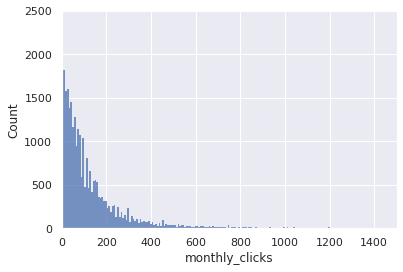

In [11]:
_ = sns.histplot(data=sp, x='monthly_clicks')
_ = plt.xlim(0, 1500)
_ = plt.ylim(0, 2500)

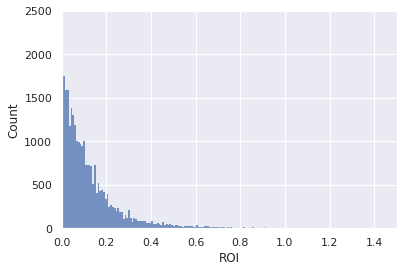

In [12]:
_ = sns.histplot(x='ROI', data=sp)
_ = plt.xlim(0, 1.5)
_ = plt.ylim(0, 2500)

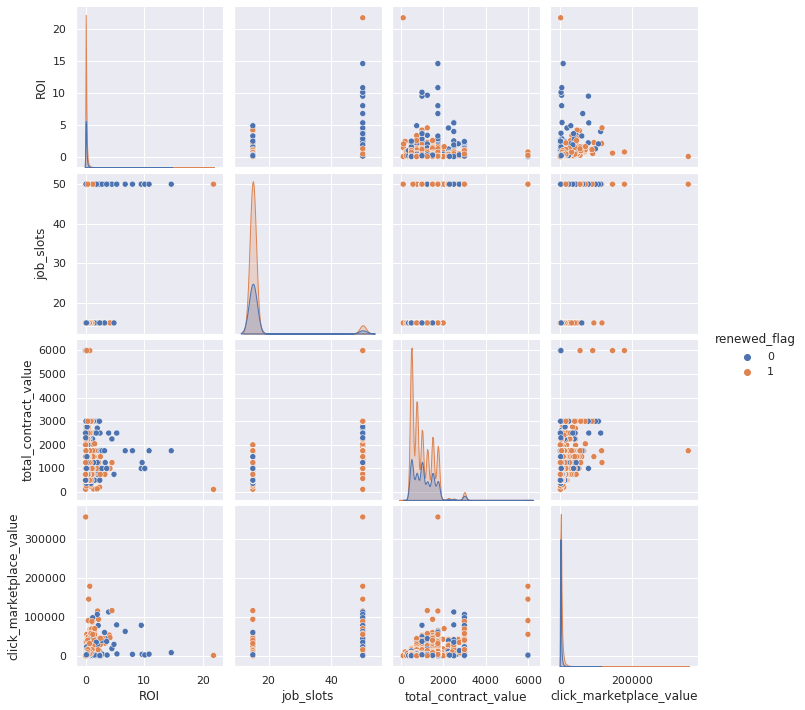

In [13]:
_ = sns.pairplot(
    data=sp[['ROI', 'job_slots', 'total_contract_value', 'click_marketplace_value', 'renewed_flag']],
    hue='renewed_flag'
)

In [14]:
sp.groupby('job_slots').agg(mean_ROI = ('ROI', 'mean'))

,mean_ROI
job_slots,
15,0.099567
50,0.252803


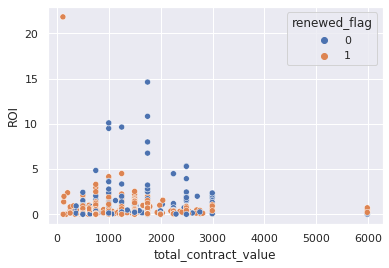

In [15]:
_ = sns.scatterplot(x='total_contract_value', y='ROI', hue='renewed_flag', data=sp)

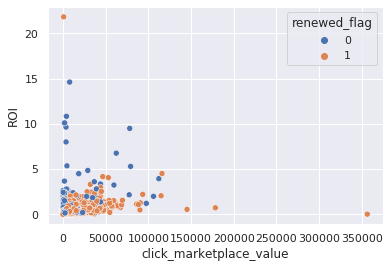

In [16]:
_ = sns.scatterplot(x='click_marketplace_value', y='ROI', hue='renewed_flag', data=sp)

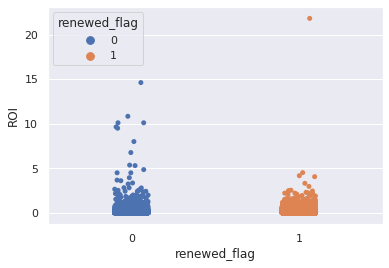

In [17]:
_ = sns.stripplot(x='renewed_flag', y='ROI', hue='renewed_flag', data=sp)

In [18]:
# Return on Investment has almost no relationship with contract renewal
sp.groupby('renewed_flag').agg(mean_ROI = ('ROI', 'mean'))

,mean_ROI
renewed_flag,
0,0.106870
1,0.108328


## PART C: Retention Modeling and Analysis

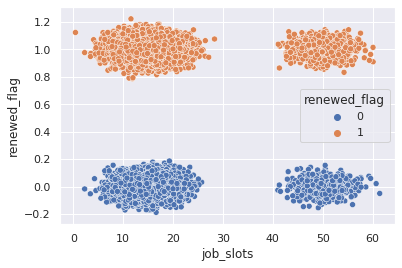

In [19]:
def jitter(values, mu, sig):
    return values + np.random.normal(mu, sig, values.shape)

_ = sns.scatterplot(
    x=jitter(sp.job_slots, 0, 3), 
    y=jitter(sp.renewed_flag, 0, 0.05), 
    hue=sp.renewed_flag
)

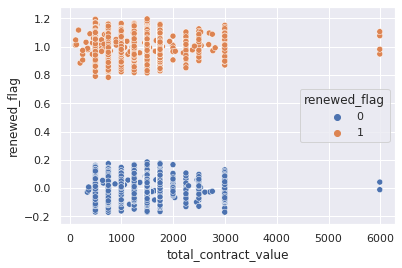

In [20]:
_ = sns.scatterplot(
    x=sp.total_contract_value, 
    y=jitter(sp.renewed_flag, 0, 0.05),
    hue=sp.renewed_flag
)

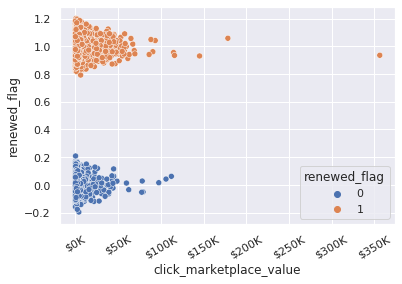

In [21]:
g = sns.scatterplot(
    x=sp.click_marketplace_value,
    y=jitter(sp.renewed_flag, 0, 0.05),
    hue=sp.renewed_flag
)
xlabels = ['${:,.0f}'.format(x) + 'K'
   for x in g.get_xticks() / 1000
]
_ = g.set_xticklabels(xlabels, rotation=30)

In [22]:
sp['cost_ratio'] =  sp['click_marketplace_value'] / sp['total_contract_value']
sp['post_completion_ratio'] = sp['job_listings'] / sp['job_slots']

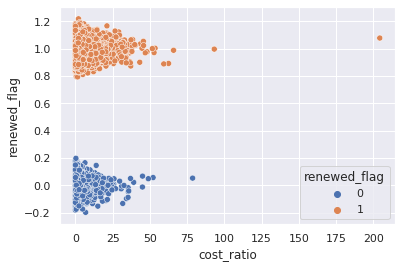

In [23]:
g = sns.scatterplot(
    x=sp.cost_ratio,
    y=jitter(sp.renewed_flag, 0, 0.05),
    hue=sp.renewed_flag
)

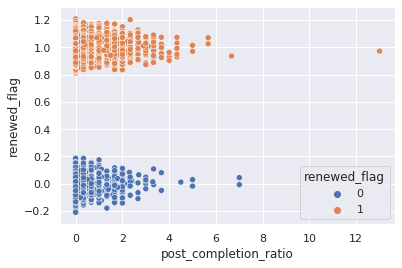

In [24]:
g = sns.scatterplot(
    x=sp.post_completion_ratio,
    y=jitter(sp.renewed_flag, 0, 0.05),
    hue=sp.renewed_flag
)

In [25]:
sp.columns

Index(['employer_id', 'city_id', 'contract_id', 'start_date', 'end_date',
       'renewed_flag', 'job_slots', 'total_contract_value', 'applications',
       'apply_start_clicks', 'click_marketplace_value', 'job_listings', 'days',
       'monthly_clicks', 'ROI', 'cost_ratio', 'post_completion_ratio'],
      dtype='object')

In [26]:
sp.shape

(37757, 17)

In [27]:
sp.columns

Index(['employer_id', 'city_id', 'contract_id', 'start_date', 'end_date',
       'renewed_flag', 'job_slots', 'total_contract_value', 'applications',
       'apply_start_clicks', 'click_marketplace_value', 'job_listings', 'days',
       'monthly_clicks', 'ROI', 'cost_ratio', 'post_completion_ratio'],
      dtype='object')

### Logistic Regression Customer Retention Model

In [125]:
features = [
    'job_slots', 'total_contract_value', 
    'click_marketplace_value', 'cost_ratio', 
    'post_completion_ratio'
]

from sklearn.preprocessing import StandardScaler
data = sp[features]
scaler = StandardScaler()
scaler.fit(data)

data = pd.DataFrame(scaler.transform(data))
data.columns = features

X_train, X_test, y_train, y_test = train_test_split(
    data, 
    sp.renewed_flag,
    test_size = 0.2,
    stratify=sp.renewed_flag
)

In [126]:
logreg = LogisticRegression(solver='liblinear', penalty='l1')
logreg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [127]:
logreg.coef_

array([[ 0.00589588, -0.16784626, -0.01521534,  0.82091986, -0.07729178]])

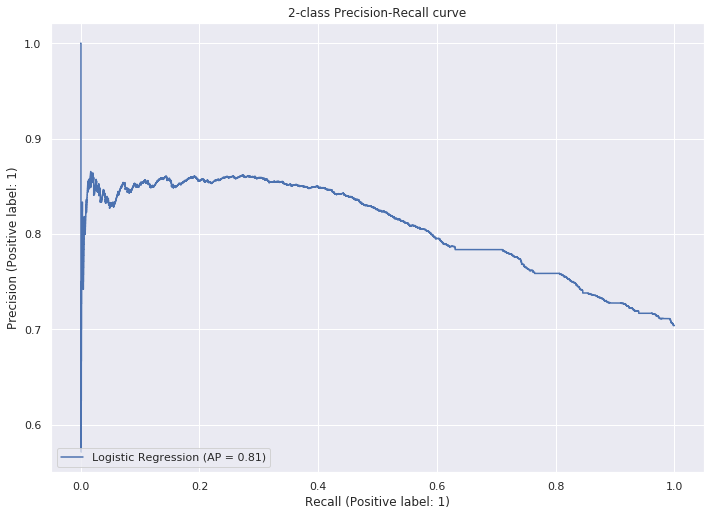

In [128]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    logreg, X_test, y_test, name="Logistic Regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [153]:
y_preds = logreg.predict_proba(X_test)[:,1]
y_pred_class = logreg.predict(X_test)

In [155]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true=y_test, 
    y_pred=y_pred_class, 
    average='binary'
)
print(f"precision:\t {precision:.3f}")
print(f"recall:\t\t {recall:.3f}")
print(f"F1:\t\t {f1:.3f}")

precision:	 0.706
recall:		 0.998
F1:		 0.827


In [145]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, y_pred=y_pred_class)

array([[  29, 2211],
       [  10, 5302]])

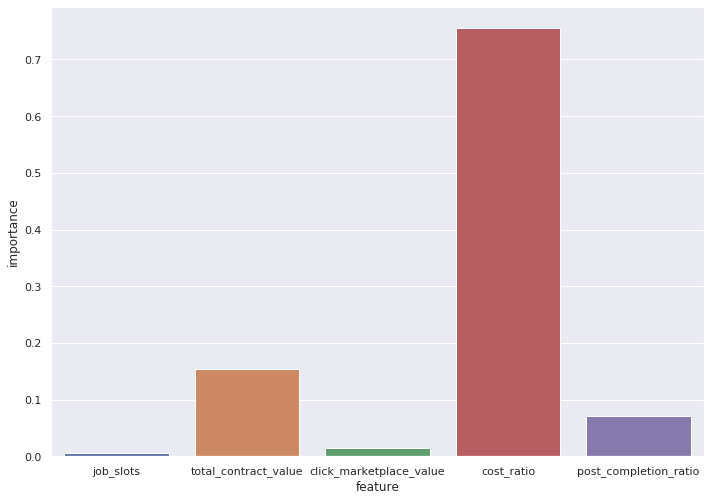

In [133]:
importance = logreg.coef_[0]
# plot feature importance
importance = abs(importance)
importance = importance / importance.sum()
importance = pd.DataFrame({'feature': features, 'importance': importance})
_ = sns.barplot(x='feature', y='importance', data=importance)

Which factors or combination of factors best predict an employer's likelihood to retain (i.e. renewed_flag = 1)? And how well does your chosen model predict retention? Please list any assumptions you made in the
modeling process and explain why you chose your methodology.
 
 


### Boosting

In [ ]:
xgb_train = xgb.DMatrix(data=X_train,label=y_train)
xgb_test = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth': 2, 'eta': 1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, xgb_train, num_round)
# make prediction
preds = bst.predict(xgb_test)


In [ ]:
preds


In [ ]:
pred_class = pd.Series([1 if p else 0 for p in preds > y_test.mean()])

In [ ]:
y_test.index

In [ ]:
pred_class.index = y_test.index

In [ ]:
gug = pd.DataFrame({'y_test': y_test, 'y_class': pred_class})

In [ ]:
sum(gug.y_test == gug.y_class) / len(gug.y_test)

In [ ]:
pred_labels = preds.round()

In [ ]:
pred_labels.mean()

In [ ]:
len(pred_labels)

In [ ]:
type(y_test)

In [ ]:
y_test

In [ ]:
(y_test == pred_labels).sum() / len(pred_labels)

In [ ]:
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

In [ ]:

feature_cols = ['cost_ratio']
X = sp.loc[:, feature_cols]
y = sp.renewed_flag

In [ ]:
X.describe()

In [ ]:
# 2. instantiate model
logreg = LogisticRegression()

# 3. fit 
logreg.fit(X[feature_cols], sp['renewed_flag'])

X_test = np.linspace(X.cost_ratio.min(), X.cost_ratio.max(), 1000)
loss = expit(X_test * logreg.coef_ + logreg.intercept_).ravel()
sns.scatterplot(x='cost_ratio', y='renewed_flag', hue='renewed_flag', data=sp)
plt.plot(X_test, loss, color='r')


In [ ]:
loss

In [ ]:
sp.renewed_flag.describe()

Based on your analysis, what modifications would you recommend we make to our ad platform algorithm to improve retention?

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import expit

# Generate a toy dataset, it's just a straight line with some Gaussian noise:
xmin, xmax = -5, 5
n_samples = 100
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0).astype(float)
X[X > 0] *= 4
X += 0.3 * np.random.normal(size=n_samples)



X = X[:, np.newaxis]

# Fit the classifier
clf = LogisticRegression(C=1e5)
clf.fit(X, y)

# and plot the result
plt.figure(1, figsize=(12, 8))
plt.clf()
plt.scatter(X.ravel(), y, color="black", zorder=20)
X_test = np.linspace(-5, 10, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color="red", linewidth=3)

# ols = LinearRegression()
# ols.fit(X, y)
# plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(0.5, color=".5")

plt.ylabel("y")
plt.xlabel("X")
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-0.25, 1.25)
plt.xlim(-4, 10)
# plt.legend(
#     ("Logistic Regression Model", "Linear Regression Model"),
#     loc="lower right",
#     fontsize="small",
# )
# plt.tight_layout()
plt.show()

## Close Connection

In [ ]:
con.close()

In [ ]:
import sklearn
print('sklearn: %s' % sklearn.__version__)